## Imports

In [66]:
%load_ext autoreload
%autoreload 2

from utils.prepare_data import prepare_short_data, prepare_full_data
from environment import Environment
from models.base_model import Base_model
from models.DQN import DQN

from datetime import timedelta
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from models.TD import ActorModel, CriticModel, ActorImprovedValue, CriticTD, critic_epoch, actor_epoch
import torch
from tqdm import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [2]:
df = prepare_full_data('data/Data_RU.xlsx')

In [361]:
env.data.head()

,Date,Weekday,AFKS_close,AFKS_high,AFKS_low,AFKS_open,AFKS_volume,AFKS_D1,AFKS_D2,AFKS_D3,AFKS_D4
1002,2021-12-17,4,23.255,23.751,22.781,23.501,44723500.0,0.044535,-0.010468,0.010638,0.031605
1003,2021-12-20,0,22.499,23.198,22.400,23.198,37123100.0,0.024601,-0.030132,0.000000,0.035625
1004,2021-12-21,1,22.641,23.077,22.382,22.697,31016200.0,0.007860,-0.002467,0.016742,0.014074
1005,2021-12-22,2,22.520,22.946,22.308,22.700,37632400.0,0.016115,-0.007930,0.010837,0.017572
1006,2021-12-23,3,22.340,22.838,22.072,22.610,34848700.0,0.012766,-0.011942,0.010084,0.024375


In [363]:
start_date = env.first_date()

## DQN

In [3]:
# 15 is random nummber in [10, days_count] here
dqn = DQN(env.observation_tensor(15).shape[0], 3, env, batch_size=32)
dqn.fit()

NameError: name 'env' is not defined

In [ ]:
env.reset()
for i in range(10, env.day_count-1):
    obs = env.observation_tensor(i)
    action = dqn.predict(obs)
    
    reward = env.reward(i, action)
    state = env.observation_tensor(i)
#     model.fit(state, action, reward)
    
    env.transition(i, action)

In [4]:
plt.plot(range(10, env.day_count), env.money)

NameError: name 'env' is not defined

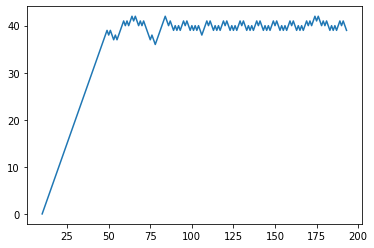

In [391]:
plt.plot(range(10, env.day_count), env.stocks)

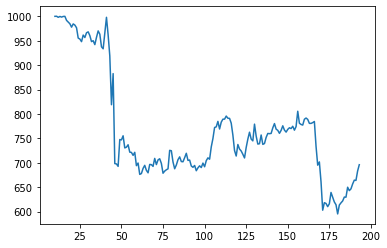

In [392]:
plt.plot(range(10, env.day_count), env.total_cost())

### Add more stocks to train on

In [39]:
env = Environment(data=df, stock_name='AFKS', initial_money=1000)
dqn = DQN(env.observation_tensor(15).shape[0],
          3,
          env,
          batch_size=128)
for s in ['AFKS', 
          'SBER',
          'YNDX',
#           'GAZP'
         ]:
    state = dqn.state_dict()
    env = Environment(data=df, stock_name=s, initial_money=1000)
    dqn.fit(state)

100%|██████████| 10000/10000 [00:54<00:00, 182.56it/s]


## Testing

In [40]:
# test_env = Environment(data=df, stock_name='MTSS', initial_money=1000)
test_env = Environment(data=df, stock_name='SBERP', initial_money=1000)

In [45]:
test_env.reset()
for i in range(10, test_env.day_count-1):
    obs = test_env.observation_tensor(i)
    action = dqn.predict(obs)
    
    reward = test_env.reward(i, action)
    state = test_env.observation_tensor(i)
#     model.fit(state, action, reward)
    
    test_env.transition(i, action)

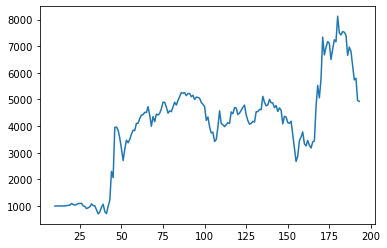

In [46]:
plt.plot(range(10, test_env.day_count), test_env.total_cost())

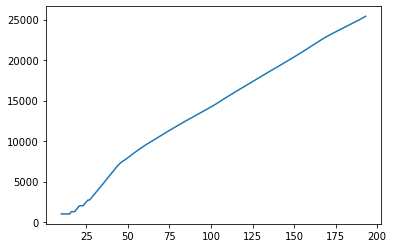

In [47]:
plt.plot(range(10, test_env.day_count), test_env.money)

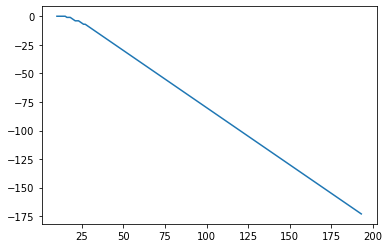

In [48]:
plt.plot(range(10, test_env.day_count), test_env.stocks)

## TD model

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

actor = ActorModel(actor_in_size=102).to(device)
critic = CriticModel(critic_in_size=102).to(device)

critic_temporal_difference = CriticTD(actor, critic, env).to(device)
actor_improved_value = ActorImprovedValue(actor, critic, env).to(device)

In [60]:
optimizer_critic_kind = torch.optim.Adam
optimizer_critic_parameters = {
    'lr': 5e-6,
    'weight_decay': 1e-5
}

optimizer_actor_kind = torch.optim.Adam
optimizer_actor_parameters = {
    "lr" : 1e-4,
    "weight_decay" : 1e-5
}

critic_iterations = 2000
critic_batch_size = 4000

actor_iterations = 2000
actor_batch_size = 2000

epochs = 5

In [67]:
optimizer_actor = optimizer_actor_kind(actor_improved_value.parameters(), **optimizer_actor_parameters)

for _ in tqdm(range(epochs), "Actor-Critic learning", leave=False):
    optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters)
    losses = np.array(critic_epoch(optimizer_critic,
                                   critic_temporal_difference,
                                   critic_iterations,
                                   env,
                                   actor_batch_size))
    actor_epoch(optimizer_actor,
                actor_improved_value,
                actor_iterations,
                env,
                actor_batch_size)
    plt.plot(losses)
    plt.show()

Actor-Critic learning:   0%|          | 0/5 [00:00<?, ?it/s]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'drop'